## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- need to go deeper as validation loss is brought in line with training loss


### Generally
- Never trust the data blindly


#### Link to models
https://drive.google.com/drive/folders/1IcfVLCy_btNzYmqzvKzyVPFQQkKrYVvZ?usp=sharing

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Nadam, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3
from keras.applications.vgg16 import VGG16

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6582281885003955759
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18001392733852251792
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9096885988078670710
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 14264138499565844030
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Constants

In [2]:
TRAIN_DATA = '/data/data/training.csv'                # train dataset downloaded from Kaggle
TEST_DATA = '/data/data/test.csv'                     # test dataset downloaded from Kaggle
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False                                    # bool to load and use existing saved models
VERBOSE_TRAIN = False                              # bool to show/hide progress while training a model
NUM_KEYPOINTS = 30                                 # maximum no. of facial keypoints for any image


## EDA on train dataset

We begin by examining the train dataset of images (training.csv file), which is organised as (x,y) coodinates of each of the 15 facial features for a total of 30 keypoints. The 31st column contains 96x96 image pixel array data coded as raw grayscale values from 0 to 255. There are a total of about 7000 images in the train dataset. 

**Summary**: 
*For the EDA, the first pass was done over the whole dataset. From this, roughly 320 images were identified that had missing keypoints or peculiarities, needing further evaluation. In this second pass, we decided to prune the input train dataset to the models, by picking out images that were misfits, and would likely end up confusing the model, rather than helping it. This analysis and some interesting images we came across are illustrated below.*


In [3]:
# Setting up the data for EDA

df_train = pd.read_csv(TRAIN_DATA)
Y = np.array(df_train[df_train.columns.difference(['Image'])])
X = df_train['Image']
labels = list(df_train.columns.difference(['Image']))

img_vec_len = IMAGE_ROWS*IMAGE_COLS                             # images pixel grid size

imgArray = np.zeros((X.shape[0], img_vec_len), dtype=int)       # temporary array to save each image as numpy array

idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx += 1
X = np.reshape( imgArray, (X.shape[0], IMAGE_ROWS, IMAGE_COLS, 1) )
print("Total images in train dataset: ", X.shape[0])

Total images in train dataset:  7049


In [4]:
# Function to subplot a group of images, and label the ones with missing keypoints distinctly

def plot_images(images, points, type='actual', subplotting=False, gridRows=0, gridCols=0, 
                imageIndices=1, subtitles=True, title=None, labelsList=[] ):
    
    plt.figure(figsize=(4*gridCols, 4*gridCols))    
    img_nums = images.shape[0]
    points_nums = points.shape[0]
    
    if ( ( img_nums != points_nums) | ( img_nums != imageIndices.shape[0] ) ):
        raise ValueError("Mismatch in number of images and keypoints' rows passed to plot_images().")
    
    
    for thisImg in range(0, gridRows*gridCols ):
        
        if subplotting:
            plt.subplot(gridRows, gridCols, thisImg + 1)
            noKeypNums  = np.isnan(points[thisImg]).sum()
            
            if subtitles:
                if( noKeypNums == 0 ):                                                            # no missing keypoints (group1)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='k')         # title in black
                
                elif( ( noKeypNums > 0) & (noKeypNums < 22 ) ):                                   # (1,21) missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='m')         # title in magenta
                
                elif( ( noKeypNums == 22 ) ):                                                     # 22 missing keypoints (group2)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='b')         # title in blue
                
                else:                                                                             # > 22 missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='r')         # title in red
        
        plt.imshow(np.reshape(images[thisImg,:],(96,96)), cmap = 'gray')

        x = 0
        for idx in range(0, points[thisImg].shape[0]):
            label = labelsList[idx]
            if label[-1]=='x':
                x = points[thisImg, idx]
            else:
                if label in ['left_eye_center_y',
                             'left_eye_inner_corner_y', 
                             'left_eye_outer_corner_y', 
                             'left_eyebrow_inner_end_y', 
                             'left_eyebrow_outer_end_y',
                             'mouth_left_corner_y'
                            ]:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'c<')
                    else:
                        plt.plot(x, points[thisImg, idx], 'c*')
                        
                elif label in ['right_eye_center_y',
                             'right_eye_inner_corner_y', 
                             'right_eye_outer_corner_y', 
                             'right_eyebrow_inner_end_y', 
                             'right_eyebrow_outer_end_y',
                              'mouth_right_corner_y']:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'r>')
                    else:
                        plt.plot(x, points[thisImg, idx], 'r*')
                
                else:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'mo')
                    else:
                        plt.plot(x, points[thisImg, idx], 'm*')
                    
        plt.axis('off')
    
    if (title != None):
        plt.suptitle(title)
    plt.show()

In [5]:
# Function to plot an array of image indices

idx_max = df_train.shape[0]                      # all images
grid_cols = 4                                    # grid columns size for a subplot of images
grid_rows = 4                                    # grid rows size for images subplot
subImgNum = grid_cols * grid_rows

def plot_img_group( thisGroup, dataset='train', denorm=False, thisLabels=labels, thisSubTitle=True, thisTitle=None ):

    if(dataset == 'train'):
        thisX = X
        thisY = Y
    elif(dataset == 'group1'):
        thisX = X1
        thisY = Y1
    elif(dataset == 'group2'):
        thisX = X2
        thisY = Y2     
    
    thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=float)
    thisSubsetY = np.zeros( (subImgNum, thisY.shape[1]), dtype=float)
    img_indices = np.zeros( (subImgNum, 1), dtype=int)

    img_sub = 0                                  # local iterator for images in subplot
    flushed = False
    for img in thisGroup:
        
        if( ( (img_sub + 1 )  % subImgNum ) != 0 ):
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            img_sub += 1
            flushed = False
            
        else:
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            
            # plot when all images for the subplot are accumulated
            plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                        gridRows=grid_rows, gridCols=grid_cols, imageIndices=img_indices, 
                        subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )
            
            # reset subplot indexing pointer and subplot image/keypoints buckets
            img_sub = 0
            flushed = True
            thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=int)
            thisSubsetY = np.zeros( (subImgNum, Y.shape[1]), dtype=float)
    
    if not flushed:                              # for images leftover from partial subplot grid

        thisGridRows = ( (img_sub - 1) // grid_rows ) + 1
        if( thisGridRows > 1 ):
            thisGridCols = grid_cols
        else:
            thisGridCols = img_sub

        plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                    gridRows=thisGridRows, gridCols=thisGridCols, imageIndices=img_indices, 
                    subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )


The images in the train dataset seem to be broadly split into two groups. The first group starts from the beginning of the dataset and (index 1, or row 1 in .csv) and continues till index 2284. Beyond that, the images have a maximum of 8 keypoints.

Below is a sample of images around this boundary - images with 30 keypoints or less and those with 8 keypoints or less. Also, there are some images with missing keypoints, with their titles highlighted in magenta or red colors.

In [10]:
# Final indices of images to be dropped from the dataset

IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )
#plot_img_group( IDX_BAD_IMAGES )

### Preparing the training data for models

In [11]:
# Function to clean up the train dataset, normalize it, drop bad images & labels, 
# and finally split the dataset into 2, for group1 and group2 modelling.

def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    
    if not test:                                                  # process train dataset
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
        
        # remove rows having bad images or labels
        X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
        Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.astype(np.float32)
    
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    
        X = X.reshape(-1, 96, 96, 1)
        
        # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
        X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        Y_model1 = np.zeros( Y.shape, dtype=float)
        Y_model2 = np.zeros( Y.shape, dtype=float)
        tempIdx1 = 0
        tempIdx2 = 0
        
        for thisIdx in range(0, Y.shape[0]):
            numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
            
            if( ( numKeyps > 8 ) ):
                X_model1[tempIdx1] = X[thisIdx,:,:]
                Y_model1[tempIdx1] = Y[thisIdx,:]
                tempIdx1 = tempIdx1 + 1
            else:
                X_model2[tempIdx2] = X[thisIdx,:,:]
                Y_model2[tempIdx2] = Y[thisIdx,:]
                tempIdx2 = tempIdx2 + 1
    
        # remove empty rows
        drop_idx1 = []
        drop_idx2 = []
        
        for idx in range(0, X.shape[0]):
            if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
                drop_idx1.append(idx)
            if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
                drop_idx2.append(idx)
        
        X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
        Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
        X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
        Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
        
        # remove empty columns, setup lists of labels
        labels = df.columns.difference(['Image'])
        labels1 = labels
        labels2 = []
        drop_idx3 = []
        for idx in range(0, Y.shape[1]):
            if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
                drop_idx3.append(idx)
            else:
                labels2.append(labels[idx])
        Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
        
        # return the original dataset and the group splits
        return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels
    
    else:                                             # for test dataset
        Y = None
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.reshape(-1, 96, 96, 1)
        labels = df.columns.difference(['Image'])
        
        return X, Y, labels
    

In [29]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [30]:
print("Group1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Group2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Group1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Group2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images

### Model Fitting Function

In [60]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=1000, patience=1000, optimizer='nadam'):
    if retrain or not os.path.exists('/data/saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=optimizer)
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat,
                                verbose=VERBOSE_TRAIN
                     )
        model.save('/data/saved-models/'+ modelname + '.h5')
        with open('/data/saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('/data/saved-models/'+modelname+'.h5')
        history = pickle.load(open( "/data/saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [55]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'c',
        4 : 'm'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

<h3>CNN_added layers model: </h3>

In [35]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [61]:
g1_model3_new = Sequential()
g1_model3_new.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Flatten())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dropout(.3))
g1_model3_new.add(Dense(30))
print(g1_model3_new.summary())
g1_CNN_aug_addedLayers_hist, g1_model3_new = fit_model(g1_model3_new, data1,'g1_CNN_aug_addedLayers',
                                                       datagen, patience=1000)
g1_CNN_aug_addedLayers_hist_adam, g1_model3_new_adam = fit_model(g1_model3_new, data1,'g1_CNN_aug_addedLayers_adam',
                                                       datagen, patience=1000, optimizer= 'adam')
g1_CNN_aug_addedLayers_hist_sgd, g1_model3_new_sgd = fit_model(g1_model3_new, data1,'g1_CNN_aug_addedLayers_sgd',
                                                       datagen, patience=1000, optimizer ='sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_130 (Bat (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_131 (Bat (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 17, 17, 256)       262400    
__________

53/53 [==============================] - 4s 70ms/step - loss: 5.4088e-04 - val_loss: 4.8801e-04
Epoch 47/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2649e-04 - val_loss: 4.8405e-04
Epoch 48/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0791e-04 - val_loss: 5.5102e-04
Epoch 49/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2458e-04 - val_loss: 4.7353e-04
Epoch 50/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2690e-04 - val_loss: 4.8924e-04
Epoch 51/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.4317e-04 - val_loss: 5.0659e-04
Epoch 52/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.7085e-04 - val_loss: 5.3518e-04
Epoch 53/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2581e-04 - val_loss: 5.3874e-04
Epoch 54/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.6730e-04 - val_loss: 5.1347e-04
Epoch 55/1000
53/53 [===

53/53 [==============================] - 4s 72ms/step - loss: 5.4565e-04 - val_loss: 4.9182e-04
Epoch 121/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2199e-04 - val_loss: 4.7974e-04
Epoch 122/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2126e-04 - val_loss: 4.7180e-04
Epoch 123/1000
53/53 [==============================] - 4s 71ms/step - loss: 5.0264e-04 - val_loss: 4.8870e-04
Epoch 124/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.3903e-04 - val_loss: 4.7697e-04
Epoch 125/1000
53/53 [==============================] - 4s 71ms/step - loss: 5.1591e-04 - val_loss: 4.8770e-04
Epoch 126/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.3840e-04 - val_loss: 4.7506e-04
Epoch 127/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.3890e-04 - val_loss: 4.7602e-04
Epoch 128/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.3564e-04 - val_loss: 4.9039e-04
Epoch 129/1000
5

Epoch 194/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1461e-04 - val_loss: 4.7533e-04
Epoch 195/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1050e-04 - val_loss: 4.7302e-04
Epoch 196/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.9905e-04 - val_loss: 4.9150e-04
Epoch 197/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1405e-04 - val_loss: 4.8349e-04
Epoch 198/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0235e-04 - val_loss: 4.9998e-04
Epoch 199/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2110e-04 - val_loss: 5.0192e-04
Epoch 200/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.5105e-04 - val_loss: 4.8436e-04
Epoch 201/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.3523e-04 - val_loss: 5.2235e-04
Epoch 202/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.4330e-04 - val_loss: 4.9333e-04
E

Epoch 268/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2147e-04 - val_loss: 5.3852e-04
Epoch 269/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.9070e-04 - val_loss: 4.7980e-04
Epoch 270/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0619e-04 - val_loss: 5.6380e-04
Epoch 271/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.8773e-04 - val_loss: 5.1114e-04
Epoch 272/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.6919e-04 - val_loss: 4.9340e-04
Epoch 273/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.3118e-04 - val_loss: 4.9065e-04
Epoch 274/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.3202e-04 - val_loss: 4.9480e-04
Epoch 275/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.9207e-04 - val_loss: 5.1632e-04
Epoch 276/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2636e-04 - val_loss: 5.7577e-04
E

Epoch 342/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1286e-04 - val_loss: 4.7772e-04
Epoch 343/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.6045e-04 - val_loss: 4.9970e-04
Epoch 344/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.5155e-04 - val_loss: 5.3155e-04
Epoch 345/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.7088e-04 - val_loss: 5.3626e-04
Epoch 346/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.1237e-04 - val_loss: 4.7697e-04
Epoch 347/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0938e-04 - val_loss: 5.3157e-04
Epoch 348/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.5701e-04 - val_loss: 4.5936e-04
Epoch 349/1000
53/53 [==============================] - 4s 72ms/step - loss: 5.5926e-04 - val_loss: 4.6521e-04
Epoch 350/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0398e-04 - val_loss: 4.7022e-04
E

Epoch 416/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.9463e-04 - val_loss: 4.9854e-04
Epoch 417/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0847e-04 - val_loss: 4.7567e-04
Epoch 418/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.8388e-04 - val_loss: 4.9809e-04
Epoch 419/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.3223e-04 - val_loss: 4.8280e-04
Epoch 420/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.3431e-04 - val_loss: 5.2081e-04
Epoch 421/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.6108e-04 - val_loss: 5.2222e-04
Epoch 422/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.6253e-04 - val_loss: 4.8280e-04
Epoch 423/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0641e-04 - val_loss: 5.3085e-04
Epoch 424/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.4297e-04 - val_loss: 5.1256e-04
E

Epoch 490/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.0885e-04 - val_loss: 5.0038e-04
Epoch 491/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2240e-04 - val_loss: 4.6586e-04
Epoch 492/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.4088e-04 - val_loss: 4.7666e-04
Epoch 493/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.0238e-04 - val_loss: 4.6594e-04
Epoch 494/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.7604e-04 - val_loss: 4.6828e-04
Epoch 495/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.4209e-04 - val_loss: 4.6084e-04
Epoch 496/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.3429e-04 - val_loss: 5.2146e-04
Epoch 497/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.8133e-04 - val_loss: 4.7424e-04
Epoch 498/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0542e-04 - val_loss: 5.5748e-04
E

Epoch 564/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.4161e-04 - val_loss: 5.0954e-04
Epoch 565/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2344e-04 - val_loss: 5.3096e-04
Epoch 566/1000
53/53 [==============================] - 4s 72ms/step - loss: 5.3725e-04 - val_loss: 4.9098e-04
Epoch 567/1000
53/53 [==============================] - 4s 71ms/step - loss: 5.7782e-04 - val_loss: 4.7934e-04
Epoch 568/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0050e-04 - val_loss: 5.0560e-04
Epoch 569/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.5235e-04 - val_loss: 5.0616e-04
Epoch 570/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1942e-04 - val_loss: 4.7789e-04
Epoch 571/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.4678e-04 - val_loss: 4.9890e-04
Epoch 572/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.9602e-04 - val_loss: 5.0285e-04
E

Epoch 638/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.0279e-04 - val_loss: 4.6872e-04
Epoch 639/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.1948e-04 - val_loss: 4.8258e-04
Epoch 640/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1915e-04 - val_loss: 5.3581e-04
Epoch 641/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.6052e-04 - val_loss: 5.0841e-04
Epoch 642/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.9618e-04 - val_loss: 4.9381e-04
Epoch 643/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.7542e-04 - val_loss: 4.6246e-04
Epoch 644/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2428e-04 - val_loss: 4.6376e-04
Epoch 645/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.6438e-04 - val_loss: 4.8399e-04
Epoch 646/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2156e-04 - val_loss: 4.8963e-04
E

Epoch 712/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2574e-04 - val_loss: 4.7575e-04
Epoch 713/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.4528e-04 - val_loss: 4.8211e-04
Epoch 714/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.8521e-04 - val_loss: 4.7324e-04
Epoch 715/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.5536e-04 - val_loss: 5.2751e-04
Epoch 716/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.1832e-04 - val_loss: 4.7669e-04
Epoch 717/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.6850e-04 - val_loss: 4.7700e-04
Epoch 718/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.2221e-04 - val_loss: 4.5301e-04
Epoch 719/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.9418e-04 - val_loss: 5.0045e-04
Epoch 720/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.3668e-04 - val_loss: 4.6743e-04
E

Epoch 786/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1540e-04 - val_loss: 4.8971e-04
Epoch 787/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.8900e-04 - val_loss: 4.9601e-04
Epoch 788/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.2337e-04 - val_loss: 4.8481e-04
Epoch 789/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.5045e-04 - val_loss: 4.8442e-04
Epoch 790/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.4124e-04 - val_loss: 5.1438e-04
Epoch 791/1000
53/53 [==============================] - 4s 69ms/step - loss: 5.2443e-04 - val_loss: 5.0917e-04
Epoch 792/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0783e-04 - val_loss: 4.8314e-04
Epoch 793/1000
53/53 [==============================] - 4s 70ms/step - loss: 6.0636e-04 - val_loss: 5.0295e-04
Epoch 794/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.4568e-04 - val_loss: 4.6554e-04
E

Epoch 860/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.8629e-04 - val_loss: 5.0478e-04
Epoch 861/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.7075e-04 - val_loss: 4.8397e-04
Epoch 862/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.2487e-04 - val_loss: 5.1879e-04
Epoch 863/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.4135e-04 - val_loss: 5.1277e-04
Epoch 864/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.9034e-04 - val_loss: 4.8147e-04
Epoch 865/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.5489e-04 - val_loss: 5.0017e-04
Epoch 866/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.5994e-04 - val_loss: 4.8433e-04
Epoch 867/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.7435e-04 - val_loss: 4.7552e-04
Epoch 868/1000
53/53 [==============================] - 4s 68ms/step - loss: 4.5679e-04 - val_loss: 4.9987e-04
E

Epoch 934/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.6936e-04 - val_loss: 4.8916e-04
Epoch 935/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.8670e-04 - val_loss: 5.0516e-04
Epoch 936/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.9172e-04 - val_loss: 4.8510e-04
Epoch 937/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.0727e-04 - val_loss: 4.8633e-04
Epoch 938/1000
53/53 [==============================] - 4s 69ms/step - loss: 4.9808e-04 - val_loss: 4.9242e-04
Epoch 939/1000
53/53 [==============================] - 4s 70ms/step - loss: 5.1262e-04 - val_loss: 5.5158e-04
Epoch 940/1000
53/53 [==============================] - 4s 71ms/step - loss: 4.9711e-04 - val_loss: 4.8132e-04
Epoch 941/1000
53/53 [==============================] - 4s 70ms/step - loss: 4.8924e-04 - val_loss: 4.6686e-04
Epoch 942/1000
53/53 [==============================] - 4s 68ms/step - loss: 5.2779e-04 - val_loss: 5.1636e-04
E

Epoch 8/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.0785e-04 - val_loss: 4.7236e-04
Epoch 9/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.0279e-04 - val_loss: 4.7228e-04
Epoch 10/1000
53/53 [==============================] - 3s 64ms/step - loss: 5.1515e-04 - val_loss: 4.7005e-04
Epoch 11/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5196e-04 - val_loss: 4.6669e-04
Epoch 12/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6648e-04 - val_loss: 4.6632e-04
Epoch 13/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4825e-04 - val_loss: 4.6609e-04
Epoch 14/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5340e-04 - val_loss: 4.6696e-04
Epoch 15/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7079e-04 - val_loss: 4.6752e-04
Epoch 16/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4323e-04 - val_loss: 4.6662e-04
Epoch 17/100

53/53 [==============================] - 3s 63ms/step - loss: 4.3756e-04 - val_loss: 4.5742e-04
Epoch 83/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7721e-04 - val_loss: 4.5746e-04
Epoch 84/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6094e-04 - val_loss: 4.5741e-04
Epoch 85/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9656e-04 - val_loss: 4.5634e-04
Epoch 86/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6294e-04 - val_loss: 4.5385e-04
Epoch 87/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9912e-04 - val_loss: 4.5533e-04
Epoch 88/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5053e-04 - val_loss: 4.5376e-04
Epoch 89/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6389e-04 - val_loss: 4.5401e-04
Epoch 90/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6931e-04 - val_loss: 4.5410e-04
Epoch 91/1000
53/53 [===

53/53 [==============================] - 3s 63ms/step - loss: 4.6903e-04 - val_loss: 4.5008e-04
Epoch 157/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9629e-04 - val_loss: 4.4997e-04
Epoch 158/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9805e-04 - val_loss: 4.5000e-04
Epoch 159/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6673e-04 - val_loss: 4.5170e-04
Epoch 160/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4529e-04 - val_loss: 4.5018e-04
Epoch 161/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.0019e-04 - val_loss: 4.4937e-04
Epoch 162/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9108e-04 - val_loss: 4.4949e-04
Epoch 163/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4070e-04 - val_loss: 4.4918e-04
Epoch 164/1000
53/53 [==============================] - 3s 64ms/step - loss: 5.0016e-04 - val_loss: 4.4969e-04
Epoch 165/1000
5

Epoch 230/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7500e-04 - val_loss: 4.4938e-04
Epoch 231/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4213e-04 - val_loss: 4.4940e-04
Epoch 232/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5258e-04 - val_loss: 4.4791e-04
Epoch 233/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5291e-04 - val_loss: 4.4812e-04
Epoch 234/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7912e-04 - val_loss: 4.4873e-04
Epoch 235/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7672e-04 - val_loss: 4.4977e-04
Epoch 236/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4761e-04 - val_loss: 4.5174e-04
Epoch 237/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7044e-04 - val_loss: 4.4807e-04
Epoch 238/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5782e-04 - val_loss: 4.4857e-04
E

Epoch 304/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.8891e-04 - val_loss: 4.4653e-04
Epoch 305/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7412e-04 - val_loss: 4.4805e-04
Epoch 306/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6489e-04 - val_loss: 4.4641e-04
Epoch 307/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.1314e-04 - val_loss: 4.4620e-04
Epoch 308/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9440e-04 - val_loss: 4.4817e-04
Epoch 309/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.8545e-04 - val_loss: 4.4728e-04
Epoch 310/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6256e-04 - val_loss: 4.4487e-04
Epoch 311/1000
53/53 [==============================] - 3s 62ms/step - loss: 4.9473e-04 - val_loss: 4.4673e-04
Epoch 312/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.8234e-04 - val_loss: 4.4618e-04
E

Epoch 378/1000
53/53 [==============================] - 3s 62ms/step - loss: 4.9875e-04 - val_loss: 4.4517e-04
Epoch 379/1000
53/53 [==============================] - 3s 62ms/step - loss: 4.7318e-04 - val_loss: 4.4418e-04
Epoch 380/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5554e-04 - val_loss: 4.4505e-04
Epoch 381/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6092e-04 - val_loss: 4.4616e-04
Epoch 382/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4542e-04 - val_loss: 4.4628e-04
Epoch 383/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6400e-04 - val_loss: 4.4415e-04
Epoch 384/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.8301e-04 - val_loss: 4.4616e-04
Epoch 385/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6519e-04 - val_loss: 4.4568e-04
Epoch 386/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6350e-04 - val_loss: 4.4552e-04
E

Epoch 452/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6591e-04 - val_loss: 4.4520e-04
Epoch 453/1000
53/53 [==============================] - 3s 63ms/step - loss: 3.9852e-04 - val_loss: 4.4617e-04
Epoch 454/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6038e-04 - val_loss: 4.4528e-04
Epoch 455/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6861e-04 - val_loss: 4.4539e-04
Epoch 456/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4939e-04 - val_loss: 4.4449e-04
Epoch 457/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5237e-04 - val_loss: 4.4555e-04
Epoch 458/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.3056e-04 - val_loss: 4.4669e-04
Epoch 459/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4389e-04 - val_loss: 4.4504e-04
Epoch 460/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.0180e-04 - val_loss: 4.4559e-04
E

Epoch 526/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.2873e-04 - val_loss: 4.4529e-04
Epoch 527/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7826e-04 - val_loss: 4.4410e-04
Epoch 528/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.1556e-04 - val_loss: 4.4431e-04
Epoch 529/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5103e-04 - val_loss: 4.4436e-04
Epoch 530/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4185e-04 - val_loss: 4.4544e-04
Epoch 531/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.3226e-04 - val_loss: 4.4501e-04
Epoch 532/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4667e-04 - val_loss: 4.4477e-04
Epoch 533/1000
53/53 [==============================] - 3s 62ms/step - loss: 5.0226e-04 - val_loss: 4.4796e-04
Epoch 534/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.8162e-04 - val_loss: 4.4527e-04
E

Epoch 600/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5915e-04 - val_loss: 4.4354e-04
Epoch 601/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6371e-04 - val_loss: 4.4371e-04
Epoch 602/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6524e-04 - val_loss: 4.4372e-04
Epoch 603/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.9987e-04 - val_loss: 4.4370e-04
Epoch 604/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.3607e-04 - val_loss: 4.4492e-04
Epoch 605/1000
53/53 [==============================] - 3s 65ms/step - loss: 4.1230e-04 - val_loss: 4.4485e-04
Epoch 606/1000
53/53 [==============================] - 3s 64ms/step - loss: 5.1006e-04 - val_loss: 4.4593e-04
Epoch 607/1000
53/53 [==============================] - 3s 65ms/step - loss: 4.4416e-04 - val_loss: 4.4387e-04
Epoch 608/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.8526e-04 - val_loss: 4.4340e-04
E

Epoch 674/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6143e-04 - val_loss: 4.4426e-04
Epoch 675/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6944e-04 - val_loss: 4.4369e-04
Epoch 676/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.3831e-04 - val_loss: 4.4433e-04
Epoch 677/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6209e-04 - val_loss: 4.4437e-04
Epoch 678/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.8484e-04 - val_loss: 4.4386e-04
Epoch 679/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7911e-04 - val_loss: 4.4276e-04
Epoch 680/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9806e-04 - val_loss: 4.4275e-04
Epoch 681/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.8601e-04 - val_loss: 4.4499e-04
Epoch 682/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4828e-04 - val_loss: 4.4517e-04
E

Epoch 748/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4821e-04 - val_loss: 4.4384e-04
Epoch 749/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.7603e-04 - val_loss: 4.4409e-04
Epoch 750/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4430e-04 - val_loss: 4.4311e-04
Epoch 751/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5020e-04 - val_loss: 4.4526e-04
Epoch 752/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.2699e-04 - val_loss: 4.4314e-04
Epoch 753/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6328e-04 - val_loss: 4.4365e-04
Epoch 754/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.2565e-04 - val_loss: 4.4264e-04
Epoch 755/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4842e-04 - val_loss: 4.4441e-04
Epoch 756/1000
53/53 [==============================] - 3s 62ms/step - loss: 4.7203e-04 - val_loss: 4.4259e-04
E

Epoch 822/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.3820e-04 - val_loss: 4.4440e-04
Epoch 823/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4682e-04 - val_loss: 4.4338e-04
Epoch 824/1000
53/53 [==============================] - 3s 63ms/step - loss: 5.4342e-04 - val_loss: 4.4435e-04
Epoch 825/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.6818e-04 - val_loss: 4.4390e-04
Epoch 826/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4023e-04 - val_loss: 4.4227e-04
Epoch 827/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6004e-04 - val_loss: 4.4275e-04
Epoch 828/1000
53/53 [==============================] - 3s 64ms/step - loss: 5.0496e-04 - val_loss: 4.4521e-04
Epoch 829/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.3365e-04 - val_loss: 4.4367e-04
Epoch 830/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6767e-04 - val_loss: 4.4219e-04
E

Epoch 896/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9948e-04 - val_loss: 4.4671e-04
Epoch 897/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5245e-04 - val_loss: 4.4518e-04
Epoch 898/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5284e-04 - val_loss: 4.4342e-04
Epoch 899/1000
53/53 [==============================] - 3s 62ms/step - loss: 4.8485e-04 - val_loss: 4.4578e-04
Epoch 900/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7402e-04 - val_loss: 4.4423e-04
Epoch 901/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.2662e-04 - val_loss: 4.4389e-04
Epoch 902/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.4440e-04 - val_loss: 4.4439e-04
Epoch 903/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.2791e-04 - val_loss: 4.4300e-04
Epoch 904/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5132e-04 - val_loss: 4.4235e-04
E

Epoch 970/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.3055e-04 - val_loss: 4.4082e-04
Epoch 971/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.5826e-04 - val_loss: 4.4118e-04
Epoch 972/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.6638e-04 - val_loss: 4.4119e-04
Epoch 973/1000
53/53 [==============================] - 3s 63ms/step - loss: 4.9227e-04 - val_loss: 4.4266e-04
Epoch 974/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4808e-04 - val_loss: 4.4284e-04
Epoch 975/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.7175e-04 - val_loss: 4.4262e-04
Epoch 976/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.5675e-04 - val_loss: 4.4293e-04
Epoch 977/1000
53/53 [==============================] - 3s 64ms/step - loss: 4.4190e-04 - val_loss: 4.4459e-04
Epoch 978/1000
53/53 [==============================] - 3s 64ms/step - loss: 5.0105e-04 - val_loss: 4.4406e-04
E

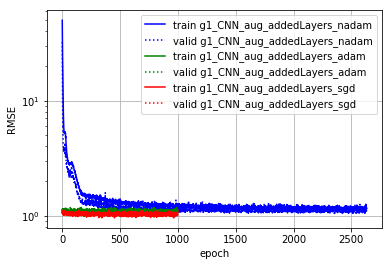

In [62]:
plot_loss([g1_CNN_aug_addedLayers_hist, g1_CNN_aug_addedLayers_hist_adam, g1_CNN_aug_addedLayers_hist_sgd],
           ['g1_CNN_aug_addedLayers_nadam','g1_CNN_aug_addedLayers_adam','g1_CNN_aug_addedLayers_sgd'])

<H3> Using VGG: </H3>

In [20]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data_vgg=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_vgg = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)



In [21]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_vgg.summary())
model_vgg_hist, model_vgg = fit_model(model_vgg, data_vgg,'g1_vgg', datagen_vgg, patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [23]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg.layers[:249]:
    layer.trainable = False
for layer in model_vgg.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist2, model_vgg2 = fit_model(model_vgg, data_vgg,'g1_vgg2',datagen_vgg, patience=1000)

# train all layers!
for layer in model_vgg.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist3, model_vgg3 = fit_model(model_vgg, data_vgg,'g1_vgg3',datagen_vgg, patience=1000)

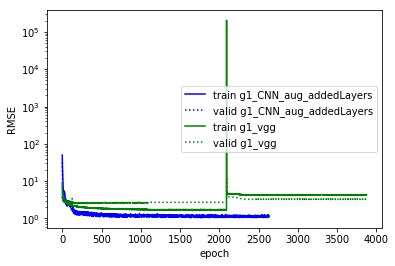

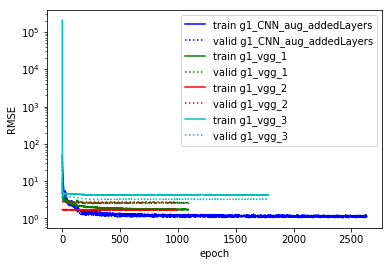

In [48]:
# compare loss
model_vgg_hist_all = {}
model_vgg_hist_all['loss'] = (model_vgg_hist['loss'] + model_vgg_hist2['loss'] + model_vgg_hist3['loss'])
model_vgg_hist_all['val_loss'] = (model_vgg_hist['val_loss'] + model_vgg_hist2['val_loss'] + model_vgg_hist3['val_loss'])

plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist_all],
           ['g1_CNN_aug_addedLayers','g1_vgg'])


plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])

### Using a model from the zoo
We try to train the InceptionV3 model to see if it does a better job. This model was chosen because it has good evaluation results, but has fewer parameters than some of the other competition-winning models.

#### Setup
In order to use InceptionV3, we need a 3 channel input. To fit this, we can just repeat the grayscale value for each of the 3 channels. We also have to change the data generator to create 3 channel images.

In [49]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data1_inceptionV3=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_inceptionV3 = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)


#### Train the model
We train the model in 3 steps.
1. Create the base model and add a global average pooling layer, a dense layer, and an output layer. Then train the 3 added layers.
1. Train layers further up from the end (layer 250 through to the output layer).
1. Train all the layers.

In [50]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_inceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_inceptionV3.summary())
model_inceptionV3_hist, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                                      'g1_zoo', datagen_inceptionV3,
                                                      patience=1000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_22 

In [51]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_inceptionV3.layers[:249]:
    layer.trainable = False
for layer in model_inceptionV3.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist2, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo2',datagen_inceptionV3,
                                patience=1000)


In [52]:
# train all layers!
for layer in model_inceptionV3.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist3, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo3',datagen_inceptionV3,
                                patience=1000)

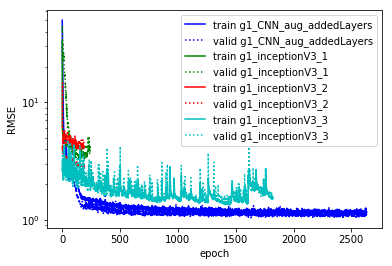

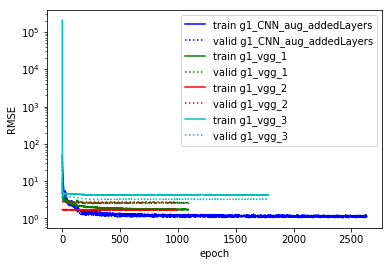

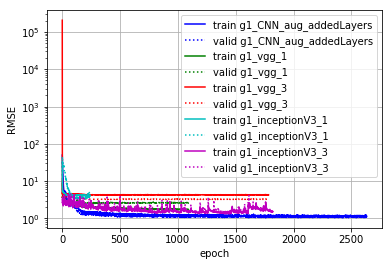

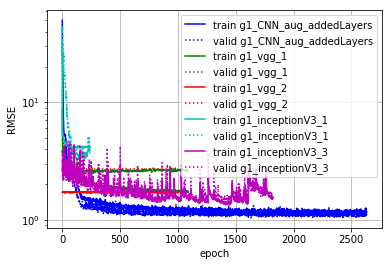

In [57]:
# compare loss
model_inceptionV3_hist_all = {}
model_inceptionV3_hist_all['loss'] = (model_inceptionV3_hist['loss'] +
                                      model_inceptionV3_hist2['loss'] +
                                      model_inceptionV3_hist3['loss']
                                      )
model_inceptionV3_hist_all['val_loss'] = (model_inceptionV3_hist['val_loss'] +
                                          model_inceptionV3_hist2['val_loss'] +
                                          model_inceptionV3_hist3['val_loss']
                                          )
plot_loss([g1_CNN_aug_addedLayers_hist, model_inceptionV3_hist, model_inceptionV3_hist2, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_inceptionV3_1','g1_inceptionV3_2','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist3, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_3','g1_inceptionV3_1','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_inceptionV3_1','g1_inceptionV3_3'])

It appears InceptionV3 loses out to our first data-augmented model. This is likely because we just don't have enough training examples to get enough variance into the Inception model that its generalization functionality works. It does appear the validation and training loss go hand in hand for the InceptionV3 model.